# **Modelos 3D para imágenes**

In [41]:
# [Config] Librerías
import os, torch
from torch.utils.data import Dataset
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
import torch


In [42]:
# [Rutas]
OUT_DIR = Path(r"C:\Users\Hp\MACHINE\MRI\datos\procesadas")
df = pd.read_csv(r"C:\Users\Hp\MACHINE\MRI\notebooks\Data\atributos.csv")

_____________

## Preprocesamiento

In [43]:
# [] Valores nulos columnas principales
print("\nNulos por columna principal:")
print(df[["is_dementia", "label_progresion"]].isna().sum().to_frame())


Nulos por columna principal:
                   0
is_dementia       28
label_progresion   0


Los valores nulos están asociados a la visita del mes 30 de x sujetos (ver EDA). Estos valores no serán imputados para los primeros 3 modelos a probar.


 Distribución de la variable objetivo:
                  proportion
label_progresion            
0                      54.84
1                      45.16

Prueba Z-test: Z = -2.29, p-value = 0.0223


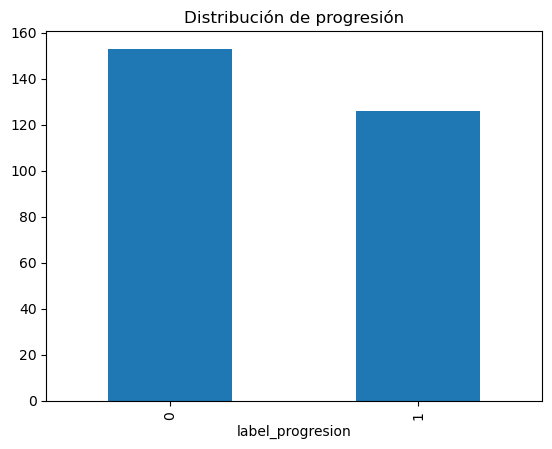

In [44]:
# [] Balance de clases
print("\n Distribución de la variable objetivo:")
print(df["label_progresion"].value_counts(normalize=True).mul(100).round(2).to_frame())
df["label_progresion"].value_counts().plot(kind="bar", title="Distribución de progresión")

# [Test] Z-test para comparar proporciones
counts = [df["label_progresion"].value_counts()[1],
          df["label_progresion"].value_counts()[0]]
nobs = [sum(counts), sum(counts)]
stat, pval = proportions_ztest(counts, nobs)
print(f"\nPrueba Z-test: Z = {stat:.2f}, p-value = {pval:.4f}")


Las clases de la variable objetivo están significativamente desbalanceadas. Se aplicará en cada modelo ponderación de clases, para no realizar replicación de imágenes que cambien la distribución real. La clase mayoritaria es que no hubo progresión de la enfermedad.

In [45]:

# Supongamos que df tiene una fila por imagen
# y las columnas: ['sujeto_id', 'label_progresion', ...]

# 1️⃣ Crear dataset único a nivel de sujeto (una fila por paciente)
df_subjects = df.groupby('sujeto_id')['label_progresion'].first().reset_index()

X = df_subjects[['sujeto_id']]
y = df_subjects['label_progresion']


# 2️⃣ Primera división: 80% trainval / 20% test (estratificada por sujeto)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trainval_idx, test_idx = next(sss1.split(X, y))

trainval_subjects = X.iloc[trainval_idx]['sujeto_id']
test_subjects = X.iloc[test_idx]['sujeto_id']

# 3️⃣ Segunda división sobre trainval: 75/25 → 60/20 total
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=24)
X_trainval = X.iloc[trainval_idx]
y_trainval = y.iloc[trainval_idx]
train_idx, val_idx = next(sss2.split(X_trainval, y_trainval))

train_subjects = X_trainval.iloc[train_idx]['sujeto_id']
val_subjects = X_trainval.iloc[val_idx]['sujeto_id']

# 4️⃣ Asignar imágenes correspondientes en el df original
X_train = df[df['sujeto_id'].isin(train_subjects)]
X_val = df[df['sujeto_id'].isin(val_subjects)]
X_test = df[df['sujeto_id'].isin(test_subjects)]

# 5️⃣ Asignar etiquetas (una por fila de imagen)
y_train = X_train['label_progresion'].values
y_val = X_val['label_progresion'].values
y_test = X_test['label_progresion'].values

# 5️⃣ Verificar proporciones
def resumen_split(df_split, name):
    print(f"{name}:")
   # Conteo absoluto de imágenes por clase
    counts = df_split['label_progresion'].value_counts()
    proportions = df_split['label_progresion'].value_counts(normalize=True) * 100
    for label in sorted(counts.index):
        print(f"  Label {label}: {counts[label]} imágenes ({proportions[label]:.2f}%)")
    print("Pacientes únicos:", df_split['sujeto_id'].nunique())
    print("Total de imágenes:", len(df_split))
    print()

resumen_split(X_train, "Train")
resumen_split(X_val, "Valid")
resumen_split(X_test, "Test")


splits_dir = OUT_DIR / "splits"
splits_dir.mkdir(exist_ok=True)

X_train.to_csv(splits_dir / "train.csv", index=False)
X_val.to_csv(splits_dir / "val.csv", index=False)
X_test.to_csv(splits_dir / "test.csv", index=False)



Train:
  Label 0: 89 imágenes (53.94%)
  Label 1: 76 imágenes (46.06%)
Pacientes únicos: 30
Total de imágenes: 165

Valid:
  Label 0: 37 imágenes (59.68%)
  Label 1: 25 imágenes (40.32%)
Pacientes únicos: 10
Total de imágenes: 62

Test:
  Label 0: 27 imágenes (51.92%)
  Label 1: 25 imágenes (48.08%)
Pacientes únicos: 11
Total de imágenes: 52



Los conjuntos de entrenamiento, validación y prueba mantienen una distribución equilibrada entre las clases “progresión” y “no progresión”.
En el conjunto de entrenamiento, el 46% de las imágenes corresponde a sujetos con progresión, mientras que en validación y prueba las proporciones son del 40% y 48%, respectivamente.
Estas cifras reflejan una estratificación adecuada respecto al balance original del dataset (≈45% progresión).

In [46]:
# 🧭 Revisar dimensiones de cada conjunto
print("=== Dimensiones de los conjuntos ===")
print(f"X_train: {X_train.shape}   | y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}     | y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}    | y_test:  {y_test.shape}")

# 📋 Verificación adicional (opcional)
print("\n=== Verificación de tipos ===")
print("X_train columnas:", X_train.columns.tolist()[:8], "...")  # muestra primeras 8
print("Etiquetas únicas en y_train:", set(y_train))


=== Dimensiones de los conjuntos ===
X_train: (165, 27)   | y_train: (165,)
X_val:   (62, 27)     | y_val:   (62,)
X_test:  (52, 27)    | y_test:  (52,)

=== Verificación de tipos ===
X_train columnas: ['sujeto_id', 'id_visita', 'Fecha', 'VISCODE', 'vis_month', 'is_dementia', 'label_progresion', 'ruta_npy'] ...
Etiquetas únicas en y_train: {0, 1}


Para el entrenamiento de los modelos se tienen 27 atributos de imágenes, para 165-62-52 imágenes en cada split, para dos etiquetas únicas.

_________
## Preprocesamiento de imgágenes

In [58]:
train_ds = MRIDataset(X_train)
val_ds = MRIDataset(X_val)
test_ds = MRIDataset(X_test)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)
test_loader = DataLoader(test_ds, batch_size=4)

In [57]:
total_train = sum(imgs.shape[0] for imgs, _ in train_loader)
total_val = sum(imgs.shape[0] for imgs, _ in val_loader)
total_test = sum(imgs.shape[0] for imgs, _ in test_loader)

print("Train:", total_train)
print("Val:", total_val)
print("Test:", total_test)


Train: 165
Val: 62
Test: 52


1. Preparar datos (✔️)
2. Dataset & Dataloader
3. Modelos 3D
4. Entrenamiento
5. Evaluación
6. Comparación